In [1]:
import numpy as np
import pandas as pd
import json
import os

In [2]:
files = [os.path.join("tables", item) for item in os.listdir("tables") if item.endswith(".json")]
table_headings = [
    "variable",
    "units",
    "base-no-ML",
    "Tq-RF",
    "TqR-RF",
    "TquvR-RF",
    "TquvR-NN",
    "TqR-NN"
]

row_names = {
    "h500_rms_global_day3-7_ic_mean": "Z500 RMSE 3-7d fcst",
    "tmp850_rms_global_day3-7_ic_mean": "T850 RMSE 3-7d fcst",
    "global_surface_precipitation_rmse": "Prec RMSE time-mean",
    "land_surface_precipitation_bias": "Prec bias land-time-mean",
    "TMP200_rmse": "T200 RMSE time-mean"
}


ablation_data = []
for file in files:
    with open(file, "r") as f:
        data = json.load(f)
    if isinstance(data, dict):
        data = [data]
    for entry in data:
        variable_data = []
        
        for column in table_headings:
            variable_data.append(entry[column])
        ablation_data.append(variable_data)


tables/ablation_tmp200_time_mean_rmse.json
tables/ablation_rms_metrics.json
tables/ablation_sfc_precip.json


In [3]:
df = pd.DataFrame(ablation_data, columns=table_headings)
df

,variable,units,base-no-ML,Tq-RF,TqR-RF,TquvR-RF,TquvR-NN,TqR-NN
0,TMP200_rmse,K,3.436004,3.161889,3.064295,5.085435,3.876489,3.066255
1,h500_rms_global_day3-7_ic_mean,m,64.110222,61.860386,62.125118,59.577835,59.601078,62.356400
2,h500_rms_global_day3-7_ic_std,m,5.110781,5.426036,5.408662,7.548270,5.879304,5.019100
3,tmp850_rms_global_day3-7_ic_mean,K,3.118555,2.903081,2.833510,2.853403,2.701795,2.736298
4,tmp850_rms_global_day3-7_ic_std,K,0.138159,0.138141,0.132379,0.153304,0.145364,0.125463
5,tmp200_rms_global_day3-7_ic_mean,K,3.273267,2.944120,2.935107,4.130241,3.419798,2.969379
6,tmp200_rms_global_day3-7_ic_std,K,0.166603,0.161575,0.167017,0.227367,0.176837,0.149627
7,land_surface_precipitation_bias,mm/day,1.093459,0.796128,0.115097,0.359086,0.002964,0.036406
8,global_surface_precipitation_rmse,mm/day,3.655571,2.659678,2.538595,2.568616,2.527530,2.556271


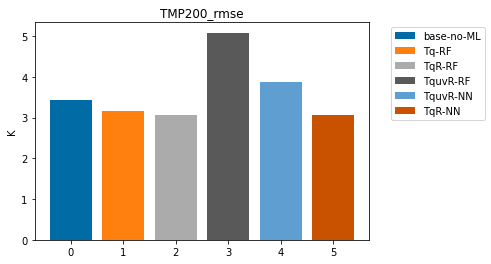

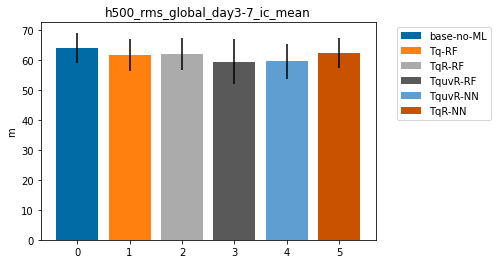

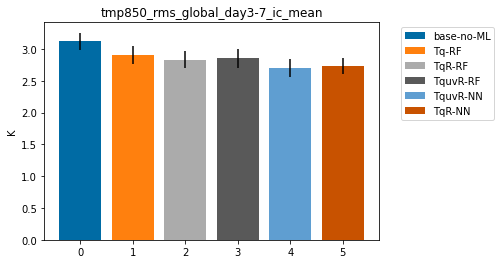

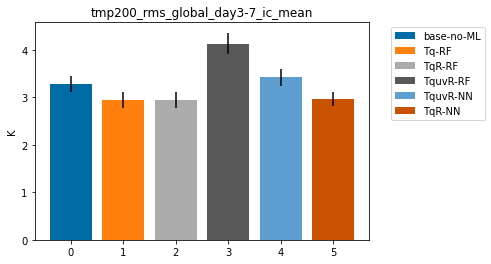

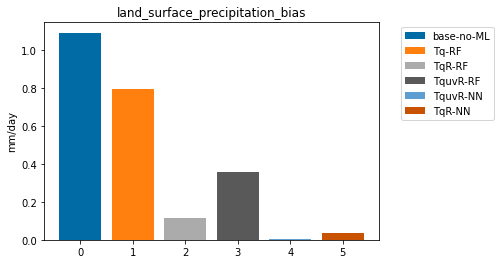

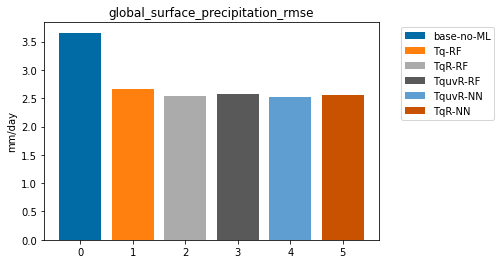

In [4]:
import matplotlib.pyplot as plt

for variable in df["variable"].values:
    if variable.endswith("std"):
        continue

    row = df.loc[ df["variable"] == variable].values[0]
    y = row[2:]
    title = row[0]
    labels = df.columns[2:].values
    units = row[1]

    if variable.endswith("mean"):
        for i in range(len(y)):
            std = df.loc[ df["variable"] == variable.replace("mean", "std")].values[0][2:]
            plt.bar([i,], [y[i],] , yerr=std[i], label=labels[i])

    else:
        for i in range(len(y)):
            plt.bar([i,], [y[i],], label=labels[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel(units)
    #plt.xaxis().set_visible(False)
    plt.title(title)
    plt.show()

#### Can copy/paste this output into the latex document.

In [5]:

print(
    df[df.variable.isin(row_names.keys())].replace(row_names).to_latex(
        index=False, 
        float_format="{:0.1f}".format,
        escape=False
    )
)

\begin{tabular}{llrrrrrr}
\toprule
                 variable &   units &  base-no-ML &  Tq-RF &  TqR-RF &  TquvR-RF &  TquvR-NN &  TqR-NN \\
\midrule
      T200 RMSE time-mean &       K &         3.4 &    3.2 &     3.1 &       5.1 &       3.9 &     3.1 \\
      Z500 RMSE 3-7d fcst &       m &        64.1 &   61.9 &    62.1 &      59.6 &      59.6 &    62.4 \\
      T850 RMSE 3-7d fcst &       K &         3.1 &    2.9 &     2.8 &       2.9 &       2.7 &     2.7 \\
 Prec bias land-time-mean &  mm/day &         1.1 &    0.8 &     0.1 &       0.4 &       0.0 &     0.0 \\
      Prec RMSE time-mean &  mm/day &         3.7 &    2.7 &     2.5 &       2.6 &       2.5 &     2.6 \\
\bottomrule
\end{tabular}



#### effect of wind tendencies (compare 2-3) on the upper atmosphere air temperature bias

In [6]:
import fsspec
import xarray as xr

def plot_zonal_pressure_bias(diags, diags_baseline, var, **plot_kwargs):
    fig = plt.figure()
    ds = xr.concat(
        [diags_baseline[[var]]] + [diags[experiment][[var]] for experiment in diags] ,
        dim=pd.Index(["baseline"] + [f"{tau} hr" for tau in diags.keys()], name="timescale")
    )

    return ds[var].plot(
        x="latitude",
        yincrease=False,
        col="timescale",
        **plot_kwargs
    )
    return fig

In [7]:
experiments = [
    "temperature-moisture-RF",
    "temperature-moisture-winds-RF",
    "temperature-moisture-winds-prescribed-sfc-RF",
    "temperature-moisture-winds-prescribed-sfc-NN-ensemble"
]

prog_run_paths = [
    "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/control-dq1-dq2-rf/initial_conditions_runs/20160805.000000",
    "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/control-rf/prognostic_run_tendencies_only_ics/20160805.000000",
    "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/initial_conditions_runs/20160805.000000",
    "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/initial_conditions_runs_rectified_nn_rad/20160805.000000"
]
paths = [f"gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/{exp}" for exp in experiments]


with fsspec.open("gs://vcm-ml-public/argo/2021-05-04-nudge-to-c3072-prog-timescales/physics-on-baseline/diags.nc", "rb") as f:
    diags_baseline = xr.open_dataset(f).load()
    
    
diags = {}
for experiment, path in zip(experiments , paths):
    print(path)
    with fsspec.open(f"{path}/diags.nc", "rb") as f:
        diags[experiment] = xr.open_dataset(f).load()

gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/temperature-moisture-RF
gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/temperature-moisture-winds-RF
gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/temperature-moisture-winds-prescribed-sfc-RF
gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/temperature-moisture-winds-prescribed-sfc-NN-ensemble


Text(95.375, 0.5, 'Pressure [Pa]')

<Figure size 432x288 with 0 Axes>

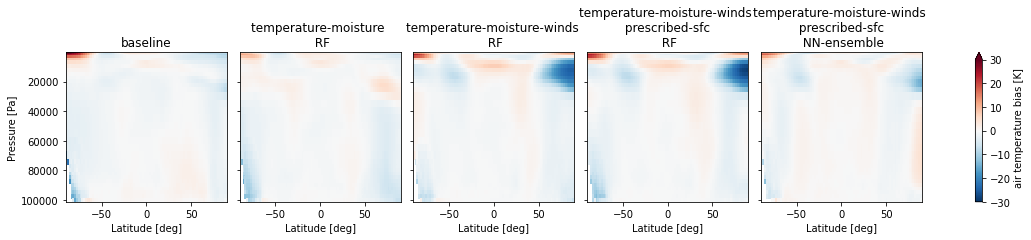

In [8]:
fig = plot_zonal_pressure_bias(diags, diags_baseline, "air_temperature_pressure_level_zonal_bias", vmax=30)
fig.cbar.set_label("air temperature bias [K]")

# plot function puts baseline first
labels = [
    "baseline",
    "temperature-moisture \n RF",
    "temperature-moisture-winds \n RF",
    "temperature-moisture-winds \n prescribed-sfc \n RF",
    "temperature-moisture-winds \n prescribed-sfc \n NN-ensemble"
]
for ax, label in zip(fig.axes[0], labels):
    ax.set_xlabel("Latitude [deg]")
    ax.set_title(label)
fig.axes[0][0].set_ylabel("Pressure [Pa]")